In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

COLOR_MODE = "rgb"
CHANNELS = 1 if COLOR_MODE == "grayscale" else 3
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

TRAINING_PATH = "./retina_dataset/Training_Set/Training_Set"
TRAINING_PATH_CSV = f"{TRAINING_PATH}/RFMiD_Training_Labels.csv"

TESTING_PATH = "./retina_dataset/Test_Set/Test_Set"
TESTING_PATH_CSV = f"{TESTING_PATH}/RFMiD_Testing_Labels.csv"

VALIDATION_PATH = "./retina_dataset/Evaluation_Set/Evaluation_Set"
VALIDATION_PATH_CSV = f"{VALIDATION_PATH}/RFMiD_Validation_Labels.csv"


train_df = pd.read_csv(TRAINING_PATH_CSV)
train_df = train_df[["ID","Disease_Risk"]]

test_df = pd.read_csv(TESTING_PATH_CSV)
test_df = test_df[["ID","Disease_Risk"]]

validation_df = pd.read_csv(VALIDATION_PATH_CSV)
validation_df = validation_df[["ID","Disease_Risk"]]


# print(train_df["Disease_Risk"].value_counts(normalize=True))
print(train_df)

for i in train_df:
    print(i)

        ID  Disease_Risk
0        1             1
1        2             1
2        3             1
3        4             1
4        5             1
...    ...           ...
1915  1916             1
1916  1917             1
1917  1918             0
1918  1919             0
1919  1920             0

[1920 rows x 2 columns]
ID
Disease_Risk


In [2]:
def append_ext(id):
        return f"{id}.png"

def convert_class(label):
        if label == 0:
            return "no"
        elif label == 1:
            return "yes"

train_df['name'] = train_df['ID'].apply(append_ext)
test_df['name'] = test_df['ID'].apply(append_ext)
validation_df['name'] = validation_df['ID'].apply(append_ext)

train_df['class'] = train_df['Disease_Risk']
test_df['class'] = test_df['Disease_Risk']
validation_df['class'] = validation_df['Disease_Risk']
# .apply(convert_class)

train_df = train_df.drop(["ID", "Disease_Risk"], axis=1)
test_df = test_df.drop(["ID", "Disease_Risk"], axis=1)
validation_df = validation_df.drop(["ID", "Disease_Risk"], axis=1)


In [3]:
display(train_df)
# display(test_df)
# display(validation_df)

,name,class
0,1.png,1
1,2.png,1
2,3.png,1
3,4.png,1
4,5.png,1
...,...,...
1915,1916.png,1
1916,1917.png,1
1917,1918.png,0
1918,1919.png,0


In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2


def create_circular_mask(image_height, image_width, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (image_width // 2, image_height // 2)
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], image_width - center[0], image_height - center[1])

    Y, X = np.ogrid[:image_height, :image_width]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)

    mask = dist_from_center <= radius
    return mask


def create_oval_mask(image_height, image_width, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (image_width // 2, image_height // 2)
    if radius is None:  # use the smallest distance between the center and image walls
        radius_x = center[0]
        radius_y = center[1]
    else:
        radius_x = radius[0]
        radius_y = radius[1]

    Y, X = np.ogrid[:image_height, :image_width]
    dist_from_center = ((X - center[0]) / radius_x) ** 2 + ((Y - center[1]) / radius_y) ** 2

    mask = dist_from_center <= 1
    return mask

def apply_mask(image, mask):
    image_array = np.array(image)  # Convert image to NumPy array
    masked_image = image_array.copy()
    masked_image[~mask] = 0
    return masked_image

def get_images_labels(image_folder_path, dataframe, limit=None, maskImages=False):
    # Load and preprocess images
	images = []
	labels = []

	if limit!=None:
		dataframe = dataframe[:limit]
	for index, row in dataframe.iterrows():
		image_path = os.path.join(image_folder_path, row['name'])
		# Assuming images are resized to (IMAGE_HEIGHT x IMAGE_HEIGHT) pixels
		image = load_img(image_path, color_mode=COLOR_MODE, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation='bilinear')
		
		if maskImages==True:
			# MASK STUFF
			center = (IMAGE_WIDTH // 2, IMAGE_HEIGHT // 2)
			# radius = min(center[0], center[1])
			# radius = 50
			# mask = create_circular_mask(IMAGE_HEIGHT, IMAGE_WIDTH, center, radius)
			radius=(50, 70)
			mask = create_oval_mask(IMAGE_HEIGHT, IMAGE_WIDTH, center, radius)
			# Apply the circular mask to an image
			masked_image = apply_mask(image, mask)
			# Rescale pixel values to [0, 1]
			final_image = img_to_array(masked_image) / 255.0
		else:
			final_image = img_to_array(image) / 255.0

		images.append(final_image)
		labels.append(row['class'])

	# Convert lists to NumPy arrays
	images = np.array(images)
	labels = np.array(labels)

	return images, labels


In [5]:
train_ds_images, train_ds_labels = get_images_labels(f"{TRAINING_PATH}/Training", train_df, limit=None, maskImages=True)
test_ds_images, test_ds_labels = get_images_labels(f"{TESTING_PATH}/Test", test_df, limit=None, maskImages=True)
validation_ds_images, validation_ds_labels = get_images_labels(f"{VALIDATION_PATH}/Validation", validation_df, limit=None, maskImages=True)
compare_ds_images, compare_ds_labels = get_images_labels(f"{VALIDATION_PATH}/Validation", validation_df, limit=5, maskImages=False)

In [6]:
import numpy as np

def randomize_dataset(images, labels):
    # Generate shuffled indices
    num_samples = len(images)
    shuffled_indices = np.random.permutation(num_samples)

    # Shuffle images and labels
    shuffled_images = images[shuffled_indices]
    shuffled_labels = labels[shuffled_indices]

    return shuffled_images, shuffled_labels

# Randomize the images in each dataset
train_ds_images, train_ds_labels = randomize_dataset(train_ds_images, train_ds_labels)
test_ds_images, test_ds_labels = randomize_dataset(test_ds_images, test_ds_labels)
validation_ds_images, validation_ds_labels = randomize_dataset(validation_ds_images, validation_ds_labels)

# Example of randomized dataset
print("Randomized train dataset:")
print(train_ds_images.shape)
print(train_ds_labels.shape)

Randomized train dataset:
(1920, 150, 150, 3)
(1920,)


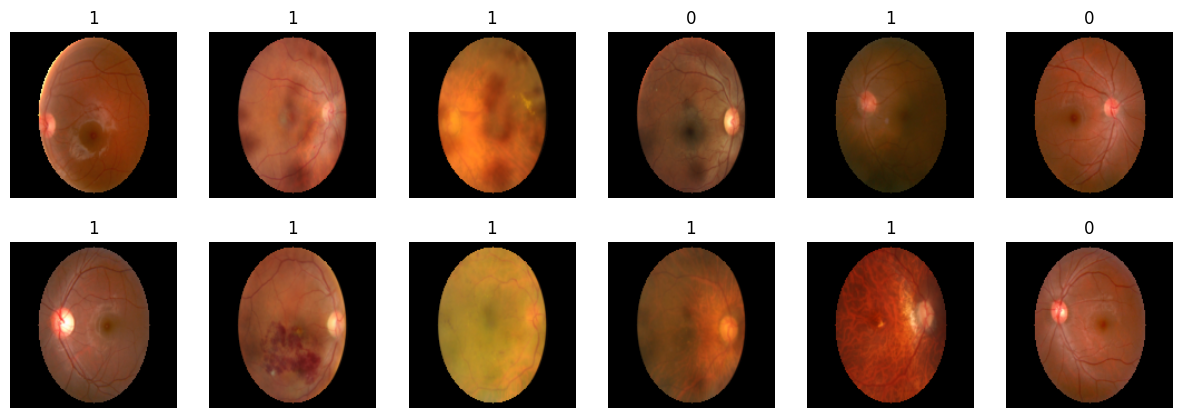

In [7]:
from matplotlib import pyplot as plt

rows, cols = 2, 6
# Create a figure and subplots with 1 row and 3 columns
fig, axes = plt.subplots(2, 6, figsize=(15, 5))
l = 0
for i in range(rows):
	for j in range(cols):
		# Plot the original image
		axes[i, j].imshow(train_ds_images[l], interpolation='bilinear')
		axes[i, j].set_title(train_ds_labels[l])
		axes[i, j].axis('off')
		axes[i, j].imshow(test_ds_images[l], interpolation='bilinear')
		axes[i, j].set_title(test_ds_labels[l])
		axes[i, j].axis('off')
		l+=1

In [8]:
# # Split data into training and testing sets
# x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
import keras

# Load pre-trained VGG16 model without classification layers
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
# base_model = InceptionV3(weights=None, include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

pre_trained_model = InceptionV3(input_shape = (150,150, 3), include_top = False, weights = None)
# pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
	layer.trainable = False
last_layer = pre_trained_model.get_layer('mixed7')

last_output = last_layer.output

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

x = keras.layers.Flatten()(last_output)
x = keras.layers.Dropout(0.5)(x) 
x = keras.layers.Dense(1024, activation='relu')(x)                 
x = keras.layers.Dense (1, activation='sigmoid')(x)           
model = Model(pre_trained_model.input, x) 
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
es= EarlyStopping(monitor='val_accuracy',mode='max', patience=2, restore_best_weights = True)
model.summary()
# # Create a new model on top
# model = keras.models.Sequential([
#     last_output,

#     # keras.layers.GlobalAveragePooling2D(),

#     keras.layers.Flatten(),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(1024, activation="relu"),
#     # keras.layers.Dropout(0.2),
#     # keras.layers.Dense(256, activation="relu"),
#     # keras.layers.Dropout(0.2),
#     # keras.layers.Dense(32, activation="relu"),
#     # keras.layers.Dropout(0.2),

#     keras.layers.Dense(1, activation="sigmoid"), #sigmoid is for binary classification
# ])

# # Compile the model
# model.compile(
#     optimizer=keras.optimizers.Adam(), 
#     loss=keras.losses.BinaryCrossentropy(),
#     metrics=[keras.metrics.BinaryAccuracy()],
# )

# model.summary(
#     expand_nested=True,
# )

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [ ]:
# import keras

# # # Define the CNN model
# # model = Sequential([
# #     Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
# #     MaxPooling2D(pool_size=(2, 2)),
# #     Conv2D(64, kernel_size=(3, 3), activation='relu'),
# #     MaxPooling2D(pool_size=(2, 2)),
# #     Flatten(),
# #     Dense(128, activation='relu'),
# #     Dense(1, activation='sigmoid')
# # ])

# model = keras.models.Sequential([
#     keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)),

#     # preprocessing,

#     # keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
#     keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Dropout(0.2),

#     keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Dropout(0.2),
    
#     keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Dropout(0.2),

#     keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Dropout(0.2),

#     keras.layers.GlobalAveragePooling2D(),

#     # keras.layers.Flatten(),
#     # keras.layers.Dropout(0.2),
#     # keras.layers.Dense(1024, activation="relu"),
#     # keras.layers.Dropout(0.2),
#     # keras.layers.Dense(256, activation="relu"),
#     # keras.layers.Dropout(0.2),
#     # keras.layers.Dense(32, activation="relu"),
#     # keras.layers.Dropout(0.2),

#     keras.layers.Dense(1, activation="sigmoid"), #sigmoid is for binary classification
# ])

# # Compile the model
# model.compile(
#     optimizer=keras.optimizers.Adam(), 
#     loss=keras.losses.BinaryCrossentropy(),
#     metrics=[keras.metrics.BinaryAccuracy()],
# )

# model.summary(
#     expand_nested=True,
# )

In [14]:
print(len(train_ds_images), len(train_ds_labels))
print(len(validation_ds_images), len(validation_ds_labels))

1920 1920
640 640


In [15]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_ds_labels), y=train_ds_labels)

# Convert class weights to a dictionary format
class_weights_dict = dict(enumerate(class_weights))

class_weights_dict

{0: 2.3940149625935163, 1: 0.6319947333772219}

In [16]:
# # Train the model
EPOCHS = 100
PATIENCE = 25
earlystop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

history = model.fit(
            x = train_ds_images,
    		y = train_ds_labels,
            validation_data = (validation_ds_images, validation_ds_labels),
            steps_per_epoch=20,
            epochs =20,
            validation_steps=5,
            verbose = 1,
            callbacks=[es]
        )

# # Train the model
# history = model.fit(
#     x = train_ds_images,
#     y = train_ds_labels,
#     epochs=EPOCHS,
#     batch_size=32,
#     validation_data=(validation_ds_images, validation_ds_labels),
#     callbacks=[earlystop_loss],
#     # class_weight=class_weights_dict,
# )

Epoch 1/20
20/20 [==============================] - 16s 413ms/step - loss: 0.5776 - accuracy: 0.7891 - val_loss: 0.5345 - val_accuracy: 0.7906
Epoch 2/20
20/20 [==============================] - 5s 254ms/step - loss: 0.5108 - accuracy: 0.7911 - val_loss: 0.5131 - val_accuracy: 0.7906
Epoch 3/20
20/20 [==============================] - 5s 262ms/step - loss: 0.5018 - accuracy: 0.7911 - val_loss: 0.5105 - val_accuracy: 0.7906


In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds_images, test_ds_labels)
print("Test Accuracy:", test_accuracy)

20/20 [==============================] - 1s 65ms/step - loss: 0.2994 - binary_accuracy: 0.8797
Test Accuracy: 0.879687488079071


Epochs run: 83


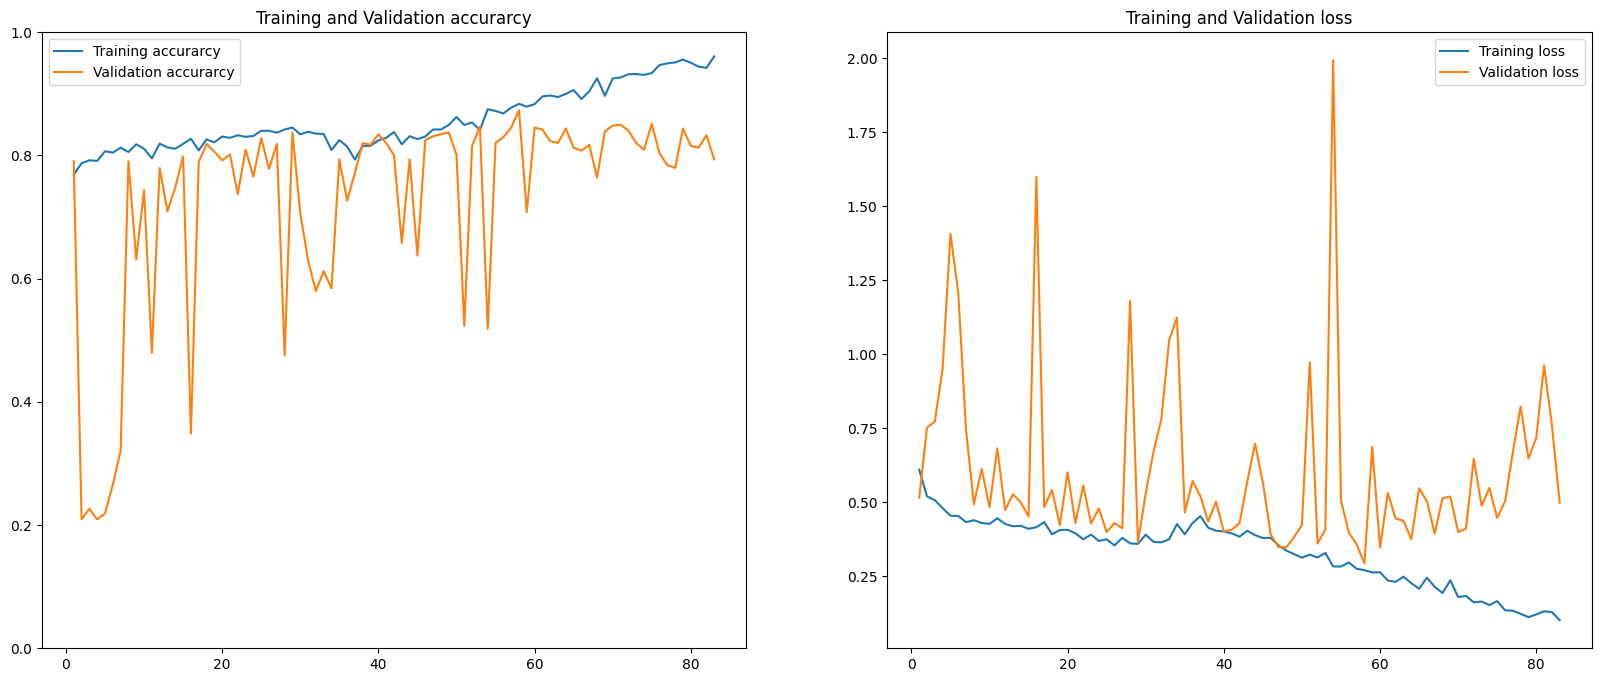

In [ ]:
from matplotlib import pyplot as plt

print("Epochs run:", len(history.history["loss"]))

acc = history.history["binary_accuracy"]
val_acc = history.history["val_binary_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.ylim((0, 1))
plt.plot(epochs, acc, label="Training accurarcy")
plt.plot(epochs, val_acc, label="Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.legend()

# Train and validation loss
plt.subplot(1, 2, 2)

plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

20/20 [==============================] - 2s 62ms/step
[[ 83  51]
 [ 26 480]]


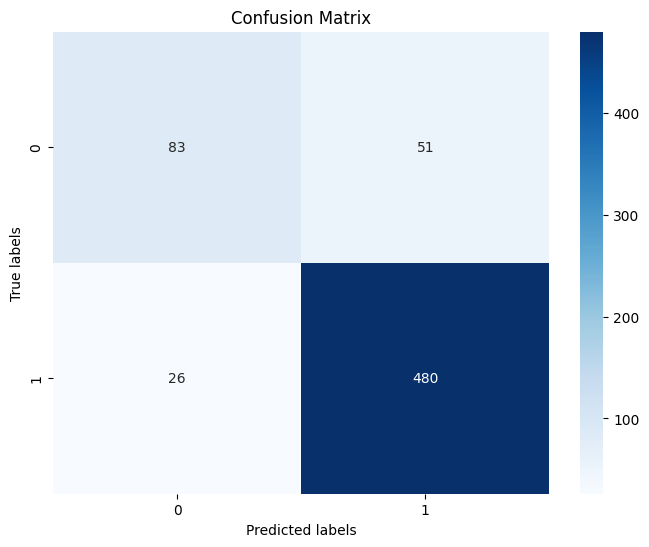

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     TESTING_FOLER,
#     image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     batch_size=32,
#     color_mode=COLOR_MODE,
#     shuffle=True,
# )

# Get true labels and predicted probabilities
true_labels = []

predictions = model.predict(test_ds_images)
# Convert probabilities to predicted labels
predicted_labels = np.where(np.array(predictions) > 0.5, 1, 0)

# Convert true labels and predicted labels to numpy arrays
true_labels = np.array(test_ds_labels)
predicted_labels = np.array(predicted_labels)

# Build the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save("retina-transfer.h5")